Links to lessons:
[Part 0](https://drscotthawley.github.io/blog/2017/02/23/Following-Gravity-Colab.html),
[Part 1](https://drscotthawley.github.io/blog/2019/01/30/My-First-Neural-Network.html), 
[Part 2](https://drscotthawley.github.io/blog/2019/02/04/My-First-NN-Part-2.html),
[Part 3](https://drscotthawley.github.io/blog/2019/02/08/My-1st-NN-Part-3-Multi-Layer-and-Backprop.html)

Moving on from our [our previous notebook](https://drscotthawley.github.io/blog/2019/01/30/My-First-Neural-Network.html), we will investigate three things we could do to improve the models developed previously:

1. Add a bias term
2. Use a different loss function
3. Add more layers to the network *(postponed to next lesson)*


## 1. Add a bias term
Our weighted sums did not include any constant offset or "bias" term.  This may be fine for some data, but not for many others.
For example, in a simple linear model $y = mx+b$, the choice of $b=0$ limits the model's ability to accurately fit some data.  

![image of bias vs no biast](https://i.imgur.com/5CbsjVW.png)

That is effectively what we did with our weighted sum $\sum_j X_{ij}w_j$: there was no constant offset.   To correct this lack, we could add a new variable $b$ and make our weighted sum $b + \sum_j X_{ij}w_j$.  Equivalently, and more conveniently for the purposes of coding, we could put an additional column of 1's in the input $X$, and a new row to our weight matrix $w$.  By convention, this is usually done with the zeroth element, so that $X_{i0}=1$ and the columns of $X$ are moved to the right, and $w_0 = b$ will be the new constant offset (because $1*w_0 = w_0$.)

For the first problem (Trask's first problem), this change makes our new matrix equation look like (with new bias terms in red)


$$
f\left(
  \overbrace{
 \left[ {\begin{array}{ccc}
   \color{red}1 & 0 & 0 & 1 \\
   \color{red}1 & 0 & 1 & 1\\
   \color{red}1 & 1 & 0 & 1\\
   \color{red}1 & 1 & 1 & 1\\
  \end{array} } \right]
}^\text{X} 
\overbrace{
   \left[ {\begin{array}{c}
   \color{red}{w_0}  \\
    w_1\\
   w_2\\
   w_3
  \end{array} } \right]
 }^{w}
\right)
  = 
  \overbrace{
 \left[ {\begin{array}{c}
   0   \\
   0  \\
   1  \\
   1 \\
  \end{array} } \right]
 }^{\tilde{Y}}
$$
***Foreshadowing***: *Note that in this problem, the rightmost column of $X$ already was a column of all 1's, and so already has something akin to a bias.  Thus, adding a new column of all 1's will not add any information, and so for this problem we expect that adding the bias won't improve the model performance.)*

With this change, we can still write our weighted sum as $\sum_j X_{ij}w_j$, it's just that $j$ now runs  over 0..3 instead of 0..2.  To emphasize: We can leave the rest of our code the same as before, provided we change $X$ by adding a column of 1's. 

In terms of coding the change to $X$, we can either rewrite it by hand, or pull a numpy trick:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# old data
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])

# add a column of 1's
new_col = np.ones((X.shape[0],1)) # array of 1s, w/ same # of rows as X, 1 col wide
X_bias = np.hstack((new_col,X))   # stack them horizontally

print(X_bias)

[[1. 0. 0. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 1.]]


Let's compare our the use of the bias term without. We'll define functions for the gradient descent and for the plotting of the loss history, so we can call these again later in this lesson.

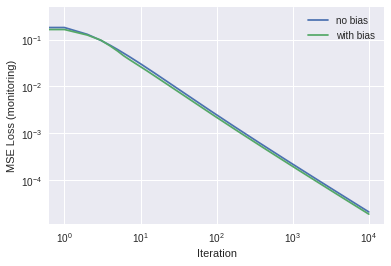

No bias: Y_pred = [[0.00553557]
 [0.00451069]
 [0.99632065]
 [0.9954838 ]]
With bias: Y_pred = [[0.00485703]
 [0.00433876]
 [0.99612094]
 [0.99565733]]


In [ ]:
Y = np.array([[0,0,1,1]]).T  # target output dataset 

def sigmoid(x,deriv=False): 
  if(deriv==True):
    return x*(1-x)
  return 1/(1+np.exp(-x))


def calc_loss(Y_pred, Y, X, w, activ, loss_type="mse"):  # MSE loss
  diff = Y_pred - Y
  loss = (diff**2).mean()
  gradient = np.dot( X.T, diff*activ(Y_pred, deriv=True)) # for weight update
  return loss, gradient


def fit(X, Y, activ, use_bias=True, alpha=3.0, maxiter=10000, loss_type='mse'):
  """
  fit: Generic routine for doing our gradient decent

  Required arguments:
      X:     input matrix
      Y:     target output
      activ: reference to an activation function
      
  Keywork arguments (optional):
      use_bias: Flag for whether to use bias in the model
      alpha:    learning rate. Tip: Use the largest alpha 'you can get away with'
      maxiter:  maximum number of iterations
      loss_type: Set to MSE for now but we'll extend this later. 
  """
  if use_bias:                       # add a column of 1's to X
    new_col = np.ones((X.shape[0],1)) 
    X = np.hstack((new_col,X))        

  # Define weights
  np.random.seed(1)                  # for reproducibility 
  if activ == sigmoid:
    w = 2*np.random.random((X.shape[1],Y.shape[1])) - 1  # -1..1 
  else:
    w = np.random.random((X.shape[1],Y.shape[1]))/10  # only positive weights (for later)
    
  loss_hist = []                     # start with an empty list
  for iter in range(maxiter):

    Y_pred = activ(np.dot(X,w))      # compute prediction, i.e. tilde{Y}

    loss, gradient = calc_loss(Y_pred, Y, X, w, activ, loss_type)
    loss_hist.append(loss)           # add to the history of the loss
    
    w -= alpha * gradient            # weight update

  return w, Y_pred, loss_hist        # send these values back


# Now call the fit function twice, to compare with and without bias:
w_old, Y_pred_old, loss_hist_old = fit(X, Y, sigmoid, use_bias=False)
w_new, Y_pred_new, loss_hist_new = fit(X, Y, sigmoid)

# Plot the results.  Make a function so we can call this again later
def plot_new_old(loss_hist_old, loss_hist_new, labels=["no bias", "with bias"]):
  plt.loglog(loss_hist_old, label=labels[0])
  plt.loglog(loss_hist_new, label=labels[1])
  plt.xlabel("Iteration")
  plt.ylabel("MSE Loss (monitoring)")
  plt.legend()
  plt.show()

plot_new_old(loss_hist_old, loss_hist_new)
# And print the final answers:
print("No bias: Y_pred =",Y_pred_old)
print("With bias: Y_pred =",Y_pred_new)

As expected, *for this problem*, the inclusion of bias didn't make any significant difference.  Let's try the same thing for the 7-segment display problem from Part 1.   And let's try two different runs, one with sigmoid activation, and another with ReLU:



--------- activ =  <function sigmoid>


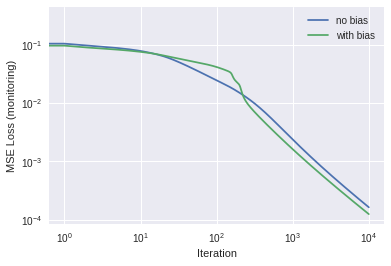

No bias: Y_pred =
 [[0.98 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.03 0.02]
 [0.01 0.98 0.00 0.01 0.01 0.00 0.00 0.02 0.00 0.00]
 [0.00 0.00 0.99 0.01 0.00 0.00 0.01 0.00 0.03 0.00]
 [0.00 0.00 0.01 0.98 0.00 0.00 0.00 0.01 0.00 0.02]
 [0.00 0.01 0.00 0.00 0.99 0.00 0.00 0.00 0.03 0.02]
 [0.00 0.00 0.00 0.01 0.01 0.98 0.02 0.00 0.00 0.02]
 [0.01 0.00 0.00 0.00 0.00 0.01 0.98 0.00 0.03 0.00]
 [0.01 0.01 0.00 0.01 0.00 0.00 0.00 0.98 0.00 0.00]
 [0.01 0.00 0.01 0.00 0.00 0.00 0.01 0.00 0.94 0.00]
 [0.00 0.00 0.00 0.01 0.01 0.01 0.00 0.00 0.02 0.96]]
With bias: Y_pred =
 [[0.98 0.00 0.00 0.00 0.00 0.00 0.01 0.01 0.03 0.01]
 [0.01 0.98 0.00 0.01 0.01 0.00 0.00 0.02 0.00 0.00]
 [0.00 0.00 0.99 0.01 0.00 0.00 0.01 0.00 0.02 0.00]
 [0.00 0.00 0.01 0.98 0.00 0.00 0.00 0.01 0.00 0.02]
 [0.00 0.01 0.00 0.00 0.99 0.00 0.00 0.00 0.02 0.02]
 [0.00 0.00 0.00 0.01 0.01 0.98 0.02 0.00 0.00 0.02]
 [0.01 0.00 0.00 0.00 0.00 0.01 0.98 0.00 0.03 0.00]
 [0.01 0.01 0.00 0.01 0.00 0.00 0.00 0.98 0.00 0.00]
 [0.0

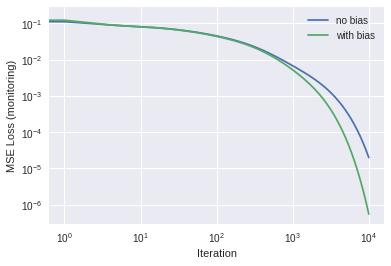

No bias: Y_pred =
 [[1.00 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00 0.00 0.01 0.00]
 [-0.00 1.00 -0.00 -0.00 0.00 -0.00 -0.00 0.00 -0.00 -0.00]
 [-0.00 -0.00 1.00 0.00 -0.00 -0.00 -0.00 -0.00 0.01 -0.00]
 [-0.00 -0.00 -0.00 1.00 -0.00 -0.00 -0.00 0.00 -0.00 0.00]
 [-0.00 0.00 -0.00 -0.00 1.00 -0.00 -0.00 -0.00 0.01 0.00]
 [-0.00 -0.00 -0.00 -0.00 -0.00 1.00 0.00 -0.00 -0.00 0.00]
 [-0.00 -0.00 -0.00 -0.00 -0.00 0.00 1.00 -0.00 0.01 -0.00]
 [0.00 0.00 -0.00 0.00 -0.00 -0.00 -0.00 1.00 -0.00 -0.00]
 [0.00 -0.00 0.00 -0.00 -0.00 -0.00 0.00 -0.00 0.96 -0.00]
 [-0.00 -0.00 -0.00 0.00 0.00 0.00 -0.00 -0.00 0.00 1.00]]
With bias: Y_pred =
 [[1.00 -0.00 -0.00 -0.00 -0.00 -0.00 -0.00 0.00 0.00 0.00]
 [-0.00 1.00 -0.00 -0.00 0.00 -0.00 -0.00 0.00 -0.00 -0.00]
 [-0.00 -0.00 1.00 0.00 -0.00 -0.00 -0.00 -0.00 0.00 -0.00]
 [-0.00 -0.00 -0.00 1.00 -0.00 -0.00 -0.00 0.00 -0.00 0.00]
 [-0.00 0.00 -0.00 -0.00 1.00 -0.00 -0.00 -0.00 0.00 0.00]
 [-0.00 -0.00 -0.00 -0.00 -0.00 1.00 0.00 -0.00 -0.00 0.00]
 [-0.00

In [ ]:
X_7seg = np.array([ [1,1,1,1,1,1,0,1],  # 0
                    [0,1,1,0,0,0,0,1],  # 1 
                    [1,1,0,1,1,0,1,1],  # 2
                    [1,1,1,1,0,0,1,1],  # 3
                    [0,1,1,0,0,1,1,1],  # 4 
                    [1,0,1,1,0,1,1,1],  # 5
                    [1,0,1,1,1,1,1,1],  # 6 
                    [1,1,1,0,0,0,0,1],  # 7 
                    [1,1,1,1,1,1,1,1],  # 8 
                    [1,1,1,1,0,1,1,1]   # 9 
                 ])
Y_7seg = np.eye(10)
X, Y = X_7seg, Y_7seg

def relu(x,deriv=False):   # relu activation
  if(deriv==True):
    return 1*(x>0) 
  return x*(x>0)


# Call the fit routine twice, once for sigmoid activation, once for relu
for activ in [sigmoid, relu]:
  print("\n\n--------- activ = ",activ)
  alpha = 0.5 if activ == sigmoid else 0.005    # assign learning rate
  w_old, Y_pred_old, loss_hist_old = fit(X, Y, activ, alpha=alpha, use_bias=False)
  w_new, Y_pred_new, loss_hist_new = fit(X, Y, activ, alpha=alpha)

  # Report results
  plot_new_old(loss_hist_old, loss_hist_new)
  np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)}) # 2 sig figs
  print("No bias: Y_pred =\n",Y_pred_old)
  print("With bias: Y_pred =\n",Y_pred_new)

...So for this problem, it seems that adding the bias gave us a bit more accuracy, both for the sigmoid and relu activations.  *Note: in this example, the learning rates were chosen by experiment; you should get in the habit of going back and experimenting with different learning rates.*  


## Video Interlude: Logistic Regression
What we've been doing up until now has been a "classification" problem, with "yes"/"no" answers represented by 1's and 0's.  This sort of operation is closely associated with the statistical method of Logistic Regression.  It is akin to linear regression but with a sigmoid activation function.  When doing Logistic Regression, one optimizes to fit by finding the maximum "likelihood" of a given model being correct.  

To gain some insight on Logistic Regression, watch the following StatQuest video.  (You can ignore his remarks about his preceding video, "R squared" and "p-value", etc.)

In [ ]:
#| echo: false
from IPython.display import HTML,IFrame
IFrame('https://www.youtube.com/embed/yIYKR4sgzI8', width=560, height=315)

In what follows, we will be *minimizing* the *negative* of the *logarithm* of the likelihood, a quantity typically known as the Cross-Entropy loss. (This same quantity is also the non-constant part of the "Kullback-Leibler Divergence" or "K-L divergence," so you may hear it called that sometimes.)

## 2. Use a different loss function: Cross-Entropy loss

Let's return to Trask's first problem for which there is only one target per data point (row) of input, namely a target of 0 or 1.  In this case, using the sigmoid function for this classification problem is one of [logistic regression](https://www.youtube.com/watch?v=yIYKR4sgzI8), even though we hadn't it identified it as such. 

We've been using mean squared error (MSE) loss, but other loss functions exist.  In particular, for outputs which are either "yes" or "no" such as the *classification problem* we are solving, a function called "[cross entropy](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy)" is typically preferred. The cross-entropy loss is written like this:

$$L_{CE} = -\sum_i \left[ Y_i\log(\tilde{Y}_i) + (1-Y_i)\log(1-\tilde{Y}_i) \right]$$

Note that since the function $\log(x)$  is undefined for $x\le0$, we need to make sure $0<\tilde{Y}_i<1$ for all $i$.  One way to ensure this is to use sigmoid activation! Thus, for classification problems, it is very common to see sigmoid activation (or its multi-class relative "[softmax](http://dataaspirant.com/2017/03/07/difference-between-softmax-function-and-sigmoid-function/)") immediately before the output, even for many-layer neural networks with all kinds of other activations in other places. 

To use the CE loss with gradient descent, we need its derivative with respect to the weights. First let's write the CE loss in terms of the inputs $X$, weights $w$ and activation function $f$:

...wait, for compactness, let's write the weighted sum as $S_i = \sum_j X_{ij}w_j$. Ok, now going forward....

$$L_{CE} = -\sum_i\left[ Y_i\log\left(f\left(S_i \right)\right) + (1-Y_i)\log\left(1- f\left(S_{i}\right)\right) \right]$$

For any function $g(x)$, the derivative of $\log(g(x))$ with respect to x is just $1/g*(du/dx)$, so our partial derivatives with respect to weights look like

$${\partial L_{CE}\over \partial w_j} = -\sum_i\left[ {Y_i\over\tilde{Y_i}}{\partial f(S_i)\over \partial w_j}  - 
{1-Y_i\over 1-\tilde{Y}_i} {\partial f(S_i)\over \partial w_j} \right]\\
= -\sum_i {\partial f(S_i) \over \partial S_i}{\partial S_i\over\partial w_j} \left[  {Y_i\over\tilde{Y_i}}  - 
{1-Y_i\over 1-\tilde{Y}_i}  \right]
$$
And if we multiply by $2/N$, we can write this as
$$
{\partial L_{CE}\over \partial w_j}
= {2\over N} \sum_{i=0}^{N-1}  {\partial f(S_i) \over \partial S_i}X_{ij}
\left[
{\tilde{Y_i}-Y_i\over \tilde{Y_i}(1-\tilde{Y_i}) }\right]$$
This is similar to the partial derivatives for our MSE loss, except the term in the denominator is new.  To see this more clearly, 
recall that the weight update for  MSE (from Part 1) was
$$
w := w - \alpha  X^T \cdot \left( [\tilde{Y}-Y]*\tilde{Y}*(1-\tilde{Y})\right)
$$
whereas for CE we actually get a bit of a simplification because the term in the denominator cancels with a similar term in the numerator:
$$
w := w - \alpha  X^T \cdot \left( [\tilde{Y}-Y]*\tilde{Y}*(1-\tilde{Y})\right) / (\tilde{Y}*(1-\tilde{Y})) \\
w := w - \alpha  X^T \cdot [\tilde{Y}-Y].
$$
Thus despite all this seeming complication, our CE weight update is actually simpler than what it was before as MSE!

Let's try this out with code now:

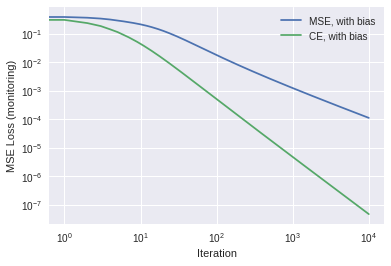

MSE _loss: Y_pred =
 [[0.01]
 [0.01]
 [0.99]
 [0.99]]
CE loss: Y_pred =
 [[0.00]
 [0.00]
 [1.00]
 [1.00]]


In [ ]:
# we'll "overwrite" the earlier calc_loss function
def calc_loss(Y_pred, Y, X, w, activ, loss_type='ce'):
  diff = Y_pred - Y
  loss = (diff**2).mean()         # MSE loss

  if 'ce' == loss_type:
    diff = diff / (Y_pred*(1-Y_pred))     # use this for gradient
    #loss = -(Y*np.log(Y_tilde) + (1-Y)*np.log1p(-Y_tilde)).mean()  # CE Loss
    #  Actually we don't care what the loss itself is. 
    #  Let's use MSE loss for 'monitoring' regardless, so we can compare the 
    #  effects of using different gradients-of-loss functions

  gradient = np.dot( X.T, diff*activ(Y_pred, deriv=True))      # same as before
  return loss, gradient

#---- 
X = X_bias
Y = np.array([[0,0,1,1]]).T  # target output dataset 

# Compare old and new
w_mse, Y_pred_mse, loss_hist_mse = fit(X, Y, sigmoid, alpha=0.5, loss_type='mse')  
w_ce, Y_pred_ce, loss_hist_ce    = fit(X, Y, sigmoid, alpha=0.5, loss_type='ce')   # fit

plot_new_old(loss_hist_mse, loss_hist_ce, ["MSE, with bias", "CE, with bias"])
# And print the final answers:
print("MSE _loss: Y_pred =\n",Y_pred_mse)
print("CE loss: Y_pred =\n",Y_pred_ce)

This works a lot better!  To understand why, note that the gradients for MSE loss scale like
$$[\tilde{Y}-Y]*\tilde{Y}*(1-\tilde{Y})$$ and thus **these gradients go to zero** as $\tilde{Y}\rightarrow 0$, and/or $\tilde{Y}\rightarrow 1$, which makes training **very slow**!   In contrast, the extra denominator in the CE gradients effectively cancels out this behavior, leaving the remaining term of 
$$[\tilde{Y}-Y]$$ which varies *linearly* with the difference from the target value. This makes training much more efficient. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


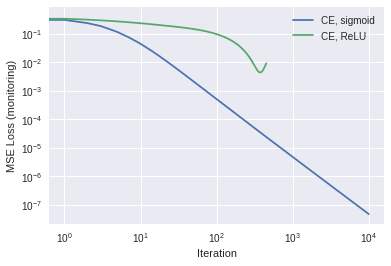

In [ ]:
# Aside: What happens if we try ReLU activation with CE loss?  Bad things, probably.
# Recall that ReLU maps negative numbers to 0, and isn't bounded from above.
#  Thus the "denominator" in the 'diff term' in our earlier code will tend to 'explode'.  
#  Put differently, note that log(x) is undefined for x=0, as is log(1-x) for x=1.
w_relu_ce, Y_pred_relu_ce, loss_hist_relu_ce = fit(X, Y, relu, alpha=0.001, loss_type='ce') 
plot_new_old(loss_hist_ce, loss_hist_relu_ce, ["CE, sigmoid", "CE, ReLU"])

# Excercise: 
Do the same comparison for the 7-segment display problem: Make a plot showing a comparison of the loss history use MSE loss vs. using CE loss. And print out the final values of `Y_pred` for each.  Use a learning rate of 0.5 and sigmoid activation, with bias. 

Take a screenshot of the output and upload it to your instructor.

(*Note:* for the 7-segment display, since the target $Y$ has multiple columns, we should "normalize" the output in order to be able to properly interpret the output values $\tilde{Y}$ as probabilities. To do so, we would use a `softmax` activation. For now, we haven't bothered with this because it would add a bit more math, and is not actually necessary to solve this problem. )

Next time: [Part 3: Multi-Layer Networks and Backpropagation](https://drscotthawley.github.io/blog/2019/02/08/My-1st-NN-Part-3-Multi-Layer-and-Backprop.html)